## load model before Quantization

In [166]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model as Kerasmodel

# load saved Baseline_BirdNET_V2.1_softmax before Quantization

keras_baselineModel_activation_path = "/home/jovyan/models/checkpoints_/baseline_two_class_model_softmax_activation/"

baselineModel_activation_softmax = tf.keras.models.load_model(keras_baselineModel_activation_path)

print("Finished loading model")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Finished loading model


## We hypothesize, the focus might be too small and gets lost during quantization, we check by visualizing activation over final dense layer outputs

#### Check model shape
---

In [2]:
baselineModel_activation_softmax.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, 144000)]             0         []                            
                                                                                                  
 ADVANCED_SPEC1 (LinearSpec  (None, 128, 513, 1)          1         ['INPUT[0][0]']               
 Layer)                                                                                           
                                                                                                  
 BNORM_SPEC_NOQUANT (BatchN  (None, 128, 513, 1)          4         ['ADVANCED_SPEC1[0][0]']      
 ormalization)                                                                                    
                                                                                            

### Dense Layer Visualizations
---
Preparation:

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


# Utility to search for layer index by name. 
# layer_idx = utils.find_layer_idx(baselineModel_activation_softmax, 'dense')


def getLayerIndexByName(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx
        
        
layer_index_dec = getLayerIndexByName(baselineModel_activation_softmax, 'dense')
print('dense layer has Index: {}.'.format(layer_index_dec))

# add linear activation not necessary, as activation follows as extra layer

dense layer has Index: 197.


##### Score function

In [4]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the target species
score = CategoricalScore(1)

##### Visualizing a specific output category:

In [5]:
from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(baselineModel_activation_softmax,
                                                 clone=True)


In [24]:
%%time
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D
import numpy as np
from scipy.io import wavfile
import audio

# Load the audio file
file_path = "/home/jovyan/cut-data/testing/non_target/1.000_0002_0XXyOMw32z8_30.wav"
input_data, sample_rate = audio.openAudioFile(file_path)

# Choose the portion of the data
input_data = audio_data[:144000]


# Use the input for activation maximization
activations = activation_maximization(score, seed_input=input_data, callbacks=[Progress()])

# Render
f, ax = plt.subplots(figsize=(4, 4))
ax.imshow(activations[0])
ax.set_title('Ouzel', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

ValueError: The dimensions of seed_input must be 3 or more (batch_size, ..., channels), but was 2.

## As this seems incompatible, we analyze the weights of the trained dense layer before quantization

In [29]:
tflite_baselineModel_softmax_activation_path = "/home/jovyan/models/checkpoints_/baseline_two_class_model_softmax_activation.tflite"

tf.lite.experimental.Analyzer.analyze(model_path=tflite_baselineModel_softmax_activation_path,
                                      model_content=None,
                                      gpu_compatibility=False)

=== /home/jovyan/models/checkpoints_/baseline_two_class_model_softmax_activation.tflite ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the REDUCE_MIN op takes
tensor #0 and tensor #117 as input and produces tensor #144 as output.

Subgraph#0 main(T#0) -> [T#406]
  Op#0 REDUCE_MIN(T#0, T#117[1]) -> [T#144]
  Op#1 SUB(T#0, T#144) -> [T#145]
  Op#2 REDUCE_MAX(T#145, T#117[1]) -> [T#146]
  Op#3 DIV(T#145, T#146) -> [T#147]
  Op#4 SHAPE(T#147) -> [T#148]
  Op#5 SPLIT_V(T#148, T#125[1, 1, 0], T#137[0]) -> [T#149, T#150, T#151]
  Op#6 RESHAPE(T#150, T#136[]) -> [T#152]
  Op#7 FLOOR_DIV(T#152, T#135[8]) -> [T#153]
  Op#8 PACK(T#153, T#135[8]) -> [T#154]
  Op#9 MUL(T#153, T#135[8]) -> [T#155]
  Op#10 RESHAPE(T#155, T#120[1]) -> [T#156]
  Op#11 CONCATENATION(T#149, T#156) -> [T#157]
  Op#12 CONCATENATION(T#149, T#154) -> [T#158]
  Op#13 STRIDED_SLICE(T#147, T#134[0, 0], T#157, T#126[1, 1]) -> [T#159]
  

### Scale both on non-target

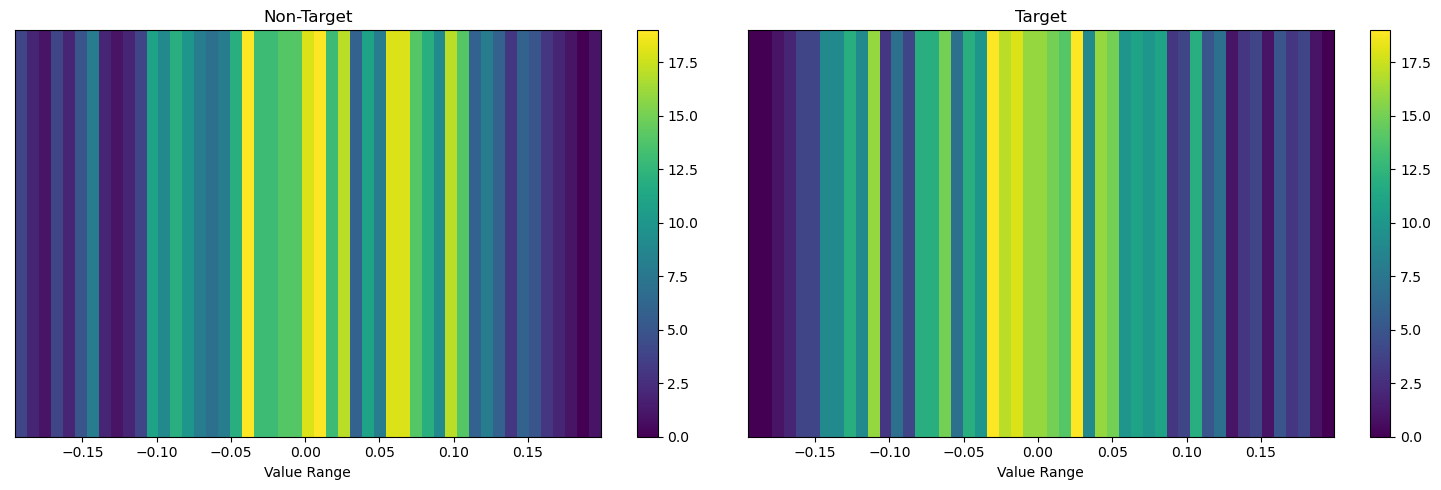

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Extract weights
weights = baselineModel_activation_softmax.get_layer('dense').get_weights()[0]

# Determine bins based on the overall range of data
bins = np.linspace(weights.min(), weights.max(), 50)

# Compute histogram for both vectors
hist1, _ = np.histogram(weights[:, 0], bins=bins)
hist2, _ = np.histogram(weights[:, 1], bins=bins)

fig, axarr = plt.subplots(1, 2, figsize=(15, 5))

# Define color scale range based on the first vector's distribution
vmin = hist1.min()
vmax = hist1.max()

# Draw heatmaps
cax1 = axarr[0].matshow(hist1.reshape(-1, 1).T, cmap="viridis", aspect="auto", extent=[bins.min(), bins.max(), 0, 1], vmin=vmin, vmax=vmax)
axarr[0].set_title("Non-Target")
axarr[0].set_xlabel("Value Range")
axarr[0].xaxis.set_ticks_position('bottom')  # Move x-axis ticks to the bottom
axarr[0].yaxis.set_visible(False)  # Hide the y-axis
plt.colorbar(cax1, ax=axarr[0])

cax2 = axarr[1].matshow(hist2.reshape(-1, 1).T, cmap="viridis", aspect="auto", extent=[bins.min(), bins.max(), 0, 1], vmin=vmin, vmax=vmax)
axarr[1].set_title("Target")
axarr[1].set_xlabel("Value Range")
axarr[1].xaxis.set_ticks_position('bottom')  # Move x-axis ticks to the bottom
axarr[1].yaxis.set_visible(False)  # Hide the y-axis
plt.colorbar(cax2, ax=axarr[1])

plt.tight_layout()
plt.show()


### Scale both on Target

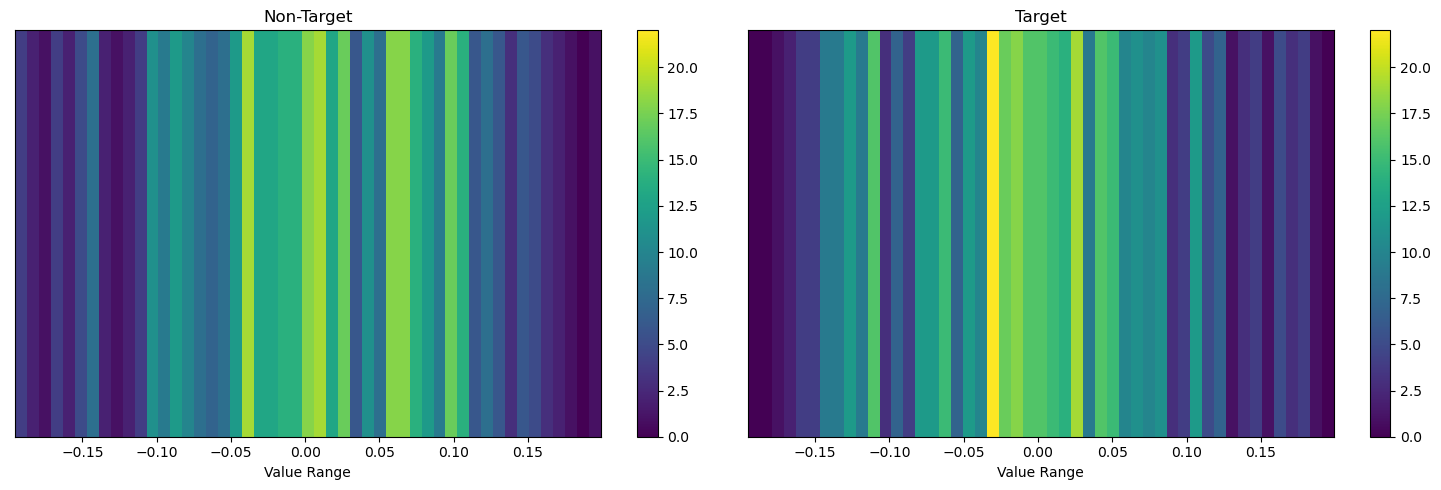

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Extract weights
weights = baselineModel_activation_softmax.get_layer('dense').get_weights()[0]

# Determine bins based on the overall range of data
bins = np.linspace(weights.min(), weights.max(), 50)

# Compute histogram for both vectors
hist1, _ = np.histogram(weights[:, 0], bins=bins)
hist2, _ = np.histogram(weights[:, 1], bins=bins)

fig, axarr = plt.subplots(1, 2, figsize=(15, 5))

# Define color scale range based on the "Target" vector's distribution
vmin = hist2.min()
vmax = hist2.max()

# Draw heatmaps
cax1 = axarr[0].matshow(hist1.reshape(-1, 1).T, cmap="viridis", aspect="auto", extent=[bins.min(), bins.max(), 0, 1], vmin=vmin, vmax=vmax)
axarr[0].set_title("Non-Target")
axarr[0].set_xlabel("Value Range")
axarr[0].xaxis.set_ticks_position('bottom')
axarr[0].yaxis.set_visible(False)
plt.colorbar(cax1, ax=axarr[0])

cax2 = axarr[1].matshow(hist2.reshape(-1, 1).T, cmap="viridis", aspect="auto", extent=[bins.min(), bins.max(), 0, 1], vmin=vmin, vmax=vmax)
axarr[1].set_title("Target")
axarr[1].set_xlabel("Value Range")
axarr[1].xaxis.set_ticks_position('bottom')
axarr[1].yaxis.set_visible(False)
plt.colorbar(cax2, ax=axarr[1])

plt.tight_layout()
plt.show()


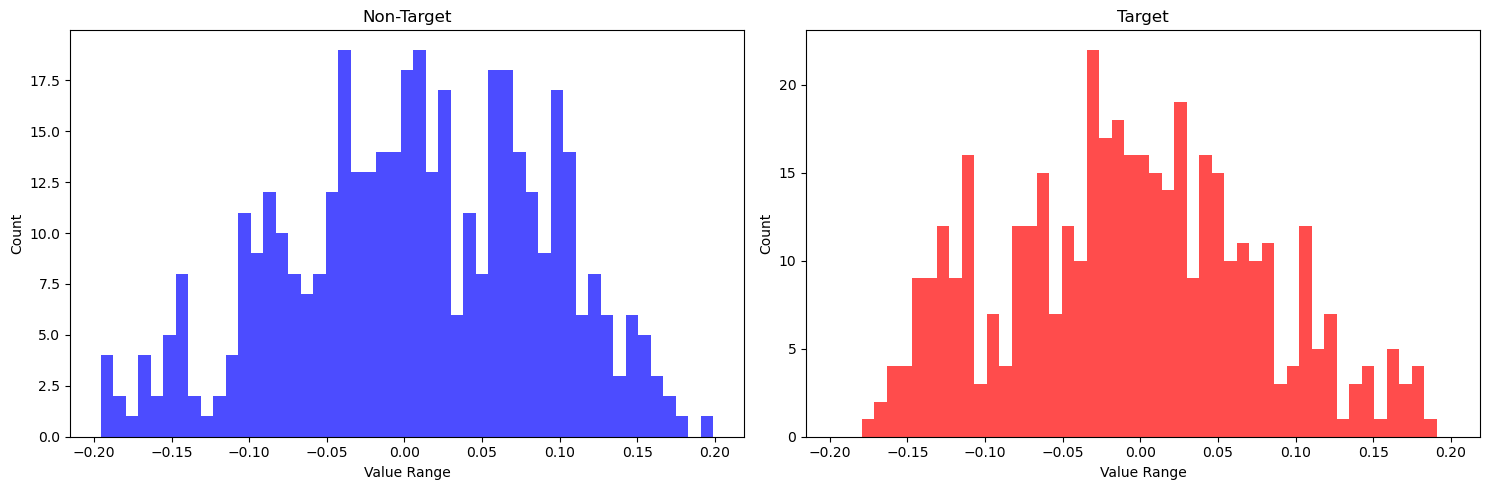

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Extract weights
weights = baselineModel_activation_softmax.get_layer('dense').get_weights()[0]

# Determine bins based on the overall range of data
bins = np.linspace(weights.min(), weights.max(), 50)

# Compute histogram for both vectors
hist1, _ = np.histogram(weights[:, 0], bins=bins)
hist2, _ = np.histogram(weights[:, 1], bins=bins)

fig, axarr = plt.subplots(1, 2, figsize=(15, 5))

# Plot histograms
axarr[0].bar(bins[:-1], hist1, width=np.diff(bins), align="edge", alpha=0.7, color='blue')
axarr[0].set_title("Non-Target")
axarr[0].set_ylabel("Count")
axarr[0].set_xlabel("Value Range")

axarr[1].bar(bins[:-1], hist2, width=np.diff(bins), align="edge", alpha=0.7, color='red')
axarr[1].set_title("Target")
axarr[1].set_ylabel("Count")
axarr[1].set_xlabel("Value Range")

plt.tight_layout()
plt.show()


### Distribution of weighting in Dense Layer, window size for smoothing

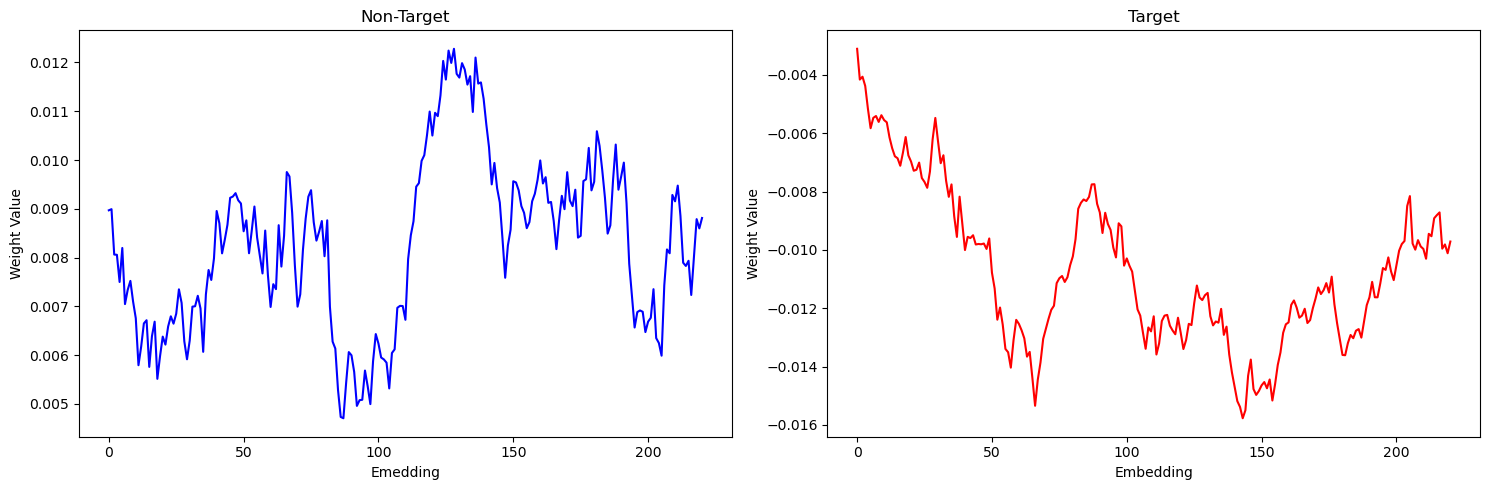

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Extract weights
weights = baselineModel_activation_softmax.get_layer('dense').get_weights()[0]

# function to compute a rolling average
def rolling_average(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

# window size for rolling average
window_size = 200

smoothed_non_target = rolling_average(weights[:, 0], window_size)
smoothed_target = rolling_average(weights[:, 1], window_size)

fig, axarr = plt.subplots(1, 2, figsize=(15, 5))

# Plot weights for Non-Target
axarr[0].plot(smoothed_non_target, color='blue')
axarr[0].set_title("Non-Target")
axarr[0].set_ylabel("Weight Value")
axarr[0].set_xlabel("Emedding")

# Plot weights for Target
axarr[1].plot(smoothed_target, color='red')
axarr[1].set_title("Target")
axarr[1].set_ylabel("Weight Value")
axarr[1].set_xlabel("Embedding")

plt.tight_layout()
plt.show()


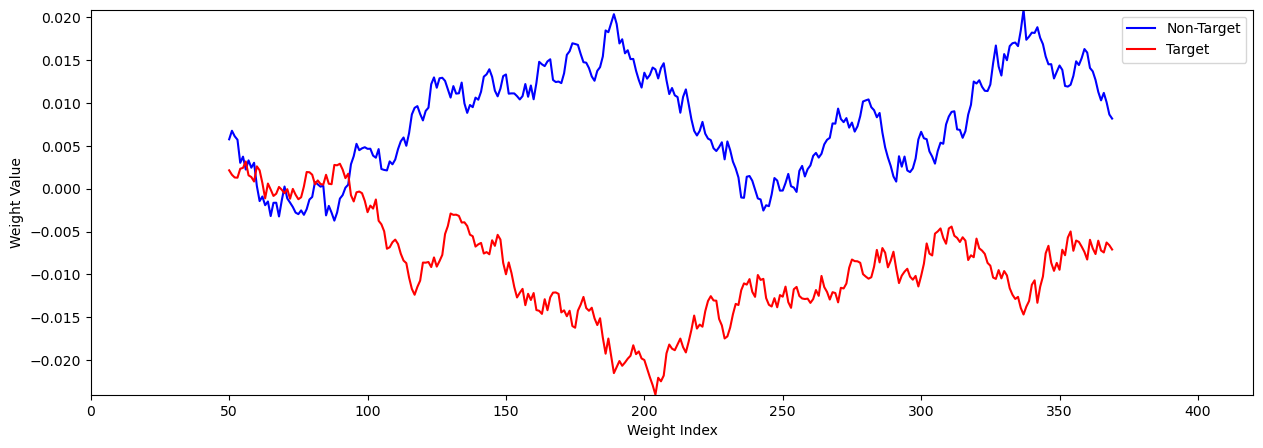

In [158]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Extract weights
weights = baselineModel_activation_softmax.get_layer('dense').get_weights()[0]

def rolling_average_resampled(data, window_size):
    half_window = window_size // 2
    smoothed_data = []

    # Handle the start of the data
    for i in range(half_window):
        smoothed_data.append(np.mean(data[:i+half_window+1]))

    # Handle the main portion of the data
    for i in range(half_window, len(data) - half_window):
        smoothed_data.append(np.mean(data[i-half_window:i+half_window+1]))

    # Handle the end of the data
    for i in range(len(data) - half_window, len(data)):
        smoothed_data.append(np.mean(data[i-half_window:]))

    return np.array(smoothed_data)

# Window size for rolling average
window_size = 100
half_window = window_size // 2

smoothed_non_target = rolling_average_resampled(weights[:, 0], window_size)
smoothed_target = rolling_average_resampled(weights[:, 1], window_size)

# Plotting
plt.figure(figsize=(15, 5))

# Determine the overall y-axis limits
ymin = min(smoothed_non_target[half_window:-half_window].min(), smoothed_target[half_window:-half_window].min())
ymax = max(smoothed_non_target[half_window:-half_window].max(), smoothed_target[half_window:-half_window].max())

# Plot weights for Non-Target
plt.plot(range(half_window, len(smoothed_non_target) - half_window), smoothed_non_target[half_window:-half_window], color='blue', label='Non-Target')

# Plot weights for Target
plt.plot(range(half_window, len(smoothed_target) - half_window), smoothed_target[half_window:-half_window], color='red', label='Target')

# Add labels, legend, etc.
plt.ylabel("Weight Value")
plt.xlabel("Weight Index")
plt.xlim(0, len(smoothed_target))
plt.ylim(ymin, ymax)
plt.legend(loc='upper right')

image_folder = 'Image'
os.makedirs(image_folder, exist_ok=True)
image_path = os.path.join(image_folder, 'weight_values_windowsize100')
plt.savefig(f"{image_path}.pdf")

plt.show()


### After Quantization

### load model

In [133]:
import tensorflow as tf

tflite_model_path = "/home/jovyan/models/checkpoints_/quantization_aware_Conv_depth_dense_INT8.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

print('Done Loading Model')

Done Loading Model


### Distribution of weighting in Dense Layer

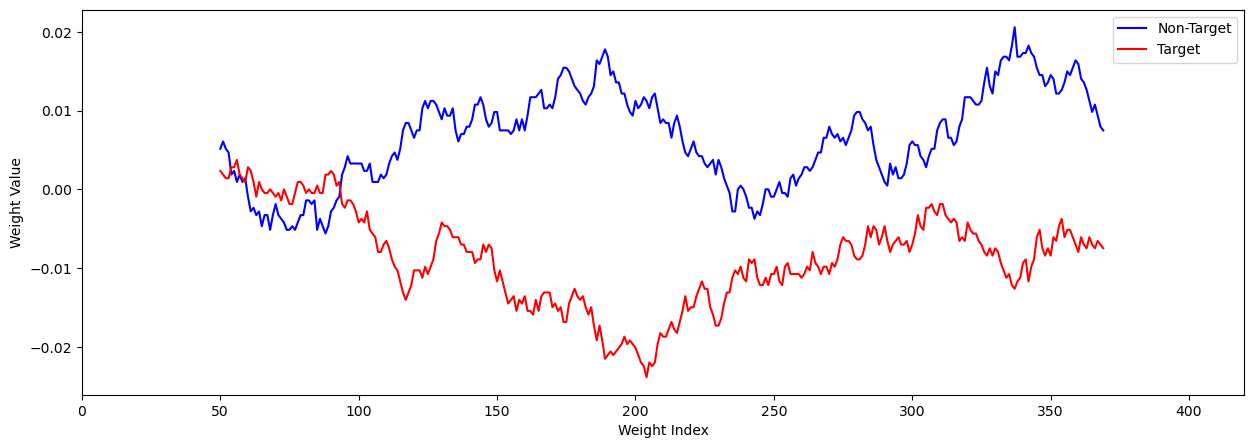

In [157]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Get weights from TFLite model
weights_tflite = interpreter.get_tensor(127)

# Transpose to get the correct shape
weights = weights_tflite.T

def rolling_average_resampled(data, window_size):
    half_window = window_size // 2
    smoothed_data = []

    # Handle the start of the data
    for i in range(half_window):
        smoothed_data.append(np.mean(data[:i+half_window+1]))

    # Handle the main portion of the data
    for i in range(half_window, len(data) - half_window):
        smoothed_data.append(np.mean(data[i-half_window:i+half_window+1]))

    # Handle the end of the data
    for i in range(len(data) - half_window, len(data)):
        smoothed_data.append(np.mean(data[i-half_window:]))

    return np.array(smoothed_data)

# Window size for rolling average
window_size = 100
half_window = window_size // 2

smoothed_non_target = rolling_average_resampled(weights[:, 0], window_size)
smoothed_target = rolling_average_resampled(weights[:, 1], window_size)

# Plotting
plt.figure(figsize=(15, 5))

# Determine the overall y-axis limits
ymin = min(smoothed_non_target[half_window:-half_window].min(), smoothed_target[half_window:-half_window].min())
ymax = max(smoothed_non_target[half_window:-half_window].max(), smoothed_target[half_window:-half_window].max())

# Plot weights for Non-Target
plt.plot(range(half_window, len(smoothed_non_target) - half_window), smoothed_non_target[half_window:-half_window], color='blue', label='Non-Target')

# Plot weights for Target
plt.plot(range(half_window, len(smoothed_target) - half_window), smoothed_target[half_window:-half_window], color='red', label='Target')

# Add labels, title, legend, etc.
plt.ylabel("Weight Value")
plt.xlabel("Weight Index")
plt.xlim(0, len(smoothed_target))
plt.legend(loc='upper right')

image_folder = 'Image'
os.makedirs(image_folder, exist_ok=True)
image_path = os.path.join(image_folder, 'weight_values_after_quant_windowsize100')
plt.savefig(f"{image_path}.pdf")

plt.show()


### Combine both, before and after Quantization

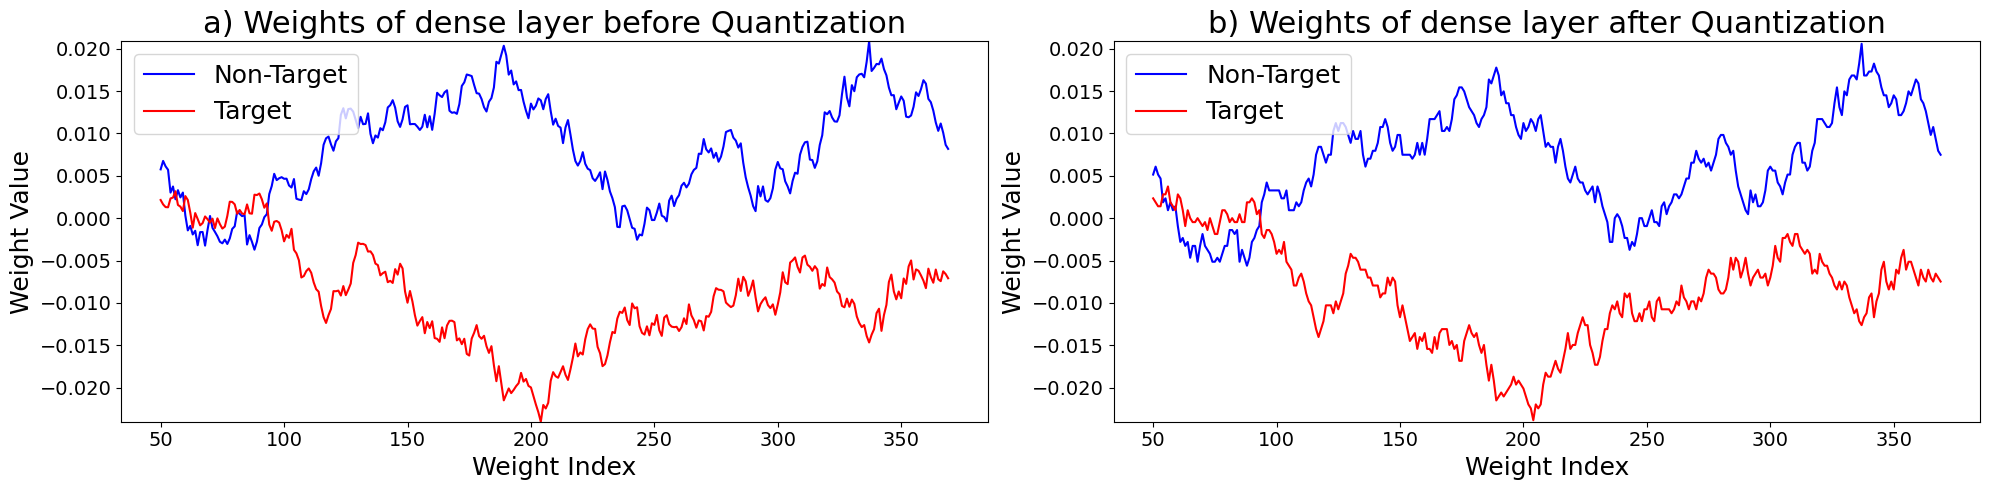

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import os

def rolling_average_resampled(data, window_size):
    half_window = window_size // 2
    smoothed_data = []

    for i in range(half_window):
        smoothed_data.append(np.mean(data[:i+half_window+1]))

    for i in range(half_window, len(data) - half_window):
        smoothed_data.append(np.mean(data[i-half_window:i+half_window+1]))

    for i in range(len(data) - half_window, len(data)):
        smoothed_data.append(np.mean(data[i-half_window:]))

    return np.array(smoothed_data)

# Window size for rolling average
window_size = 100
half_window = window_size // 2

# Get weights from baseline model
weights_baseline = baselineModel_activation_softmax.get_layer('dense').get_weights()[0]
smoothed_non_target_baseline = rolling_average_resampled(weights_baseline[:, 0], window_size)
smoothed_target_baseline = rolling_average_resampled(weights_baseline[:, 1], window_size)

# Get weights from TFLite model
weights_tflite = interpreter.get_tensor(127).T
smoothed_non_target_tflite = rolling_average_resampled(weights_tflite[:, 0], window_size)
smoothed_target_tflite = rolling_average_resampled(weights_tflite[:, 1], window_size)

fig, axarr = plt.subplots(1, 2, figsize=(20, 5))

# Determine the overall y-axis limits
ymin = min(smoothed_non_target_baseline[half_window:-half_window].min(),
           smoothed_target_baseline[half_window:-half_window].min(),
           smoothed_non_target_tflite[half_window:-half_window].min(),
           smoothed_target_tflite[half_window:-half_window].max())
ymax = max(smoothed_non_target_baseline[half_window:-half_window].max(),
           smoothed_target_baseline[half_window:-half_window].max(),
           smoothed_non_target_tflite[half_window:-half_window].max(),
           smoothed_target_tflite[half_window:-half_window].max())

# Set font sizes
title_font_size = 22
label_font_size = 18
legend_font_size = 18

# Plot weights for baseline model
axarr[0].plot(range(half_window, len(smoothed_non_target_baseline) - half_window), smoothed_non_target_baseline[half_window:-half_window], color='blue', label='Non-Target')
axarr[0].plot(range(half_window, len(smoothed_target_baseline) - half_window), smoothed_target_baseline[half_window:-half_window], color='red', label='Target')
axarr[0].set_title("a) Weights of dense layer before Quantization", fontsize=title_font_size)
axarr[0].set_ylabel("Weight Value", fontsize=label_font_size)
axarr[0].set_xlabel("Weight Index", fontsize=label_font_size)
axarr[0].legend(loc='upper left', fontsize=legend_font_size)
axarr[0].set_ylim(ymin, ymax)

# Plot weights for TFLite model
axarr[1].plot(range(half_window, len(smoothed_non_target_tflite) - half_window), smoothed_non_target_tflite[half_window:-half_window], color='blue', label='Non-Target')
axarr[1].plot(range(half_window, len(smoothed_target_tflite) - half_window), smoothed_target_tflite[half_window:-half_window], color='red', label='Target')
axarr[1].set_title("b) Weights of dense layer after Quantization", fontsize=title_font_size)
axarr[1].set_ylabel("Weight Value", fontsize=label_font_size)
axarr[1].set_xlabel("Weight Index", fontsize=label_font_size)
axarr[1].legend(loc='upper left', fontsize=legend_font_size)
axarr[1].set_ylim(ymin, ymax)

axarr[0].tick_params(axis='both', labelsize=14)
axarr[1].tick_params(axis='both', labelsize=14)

plt.tight_layout()

image_folder = 'Image'
os.makedirs(image_folder, exist_ok=True)
image_path = os.path.join(image_folder, 'combined_weight_values_windowsize100')
plt.savefig(f"{image_path}.pdf")

plt.show()


# We check the activations before the Dense Layer with standard deviation
---

## Before Quantization
---

### build model with LME Pool output

In [167]:
from keras.models import Model

# build model with LME output
activation_model = Model(inputs=baselineModel_activation_softmax.input,
                         outputs=baselineModel_activation_softmax.get_layer('GLOBAL_LME_POOL').output)

print('Done')


Done


### Load 5 Activations from Target Class

In [84]:
import os
import audio

# Helper function to load audio data and extract activations
def get_activations_from_file(file_path, model):
    # Load the audio file using the provided function
    input_data, sample_rate = audio.openAudioFile(file_path)
    
    
    input_data = np.expand_dims(input_data, axis=0)
    if len(input_data.shape) == 2:  # If data is 2D (batch_size, audio_length)
        input_data = np.expand_dims(input_data, axis=-1)  # Expand to 3D (batch_size, audio_length, 1)
    
    # Retrieve activations from the model
    activations = model.predict(input_data)
    return activations

# Specify the path to the target folder
folder_path = "/home/jovyan/cut-data/testing/target/"

# List all audio files in the target folder, but limit to first 5 for testing
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.wav')][:5]

activations_list = []
for file_path in file_paths:
    act = get_activations_from_file(file_path, activation_model)
    activations_list.append(act)
    print(f"First 3 values for {file_path.split('/')[-1]}: {act[0, :3]}")

# Combine all activations into an array
activations_array = np.vstack(activations_list)


1/1 [==============================] - 1s 824ms/step
First 3 values for 0.970_0093_669234.wav: [0.8466564  0.46071112 0.806841  ]
1/1 [==============================] - 0s 49ms/step
First 3 values for 0.940_0023_324445651.wav: [1.3941029 0.5681002 0.853912 ]
1/1 [==============================] - 0s 48ms/step
First 3 values for 0.950_0002_556972.wav: [0.4038818  1.1463783  0.55604625]
1/1 [==============================] - 0s 54ms/step
First 3 values for 0.920_0035_365517.wav: [0.9785464 0.7548368 0.4874674]
1/1 [==============================] - 0s 48ms/step
First 3 values for 0.950_0039_402581791.wav: [0.6692315  1.1404216  0.69575584]


### Calculate a standard deviation between target file activations

In [132]:
import numpy as np

# Calculate pairwise standard deviation among target activations
std_dev_target = []

num_files = len(activations_list)
for i in range(num_files):
    for j in range(i+1, num_files):  # Avoid duplicate pairs
        std_dev = np.std(activations_list[i] - activations_list[j])
        std_dev_target.append(std_dev)
        print(f"Standard deviation between target activation {i} and target activation {j}: {std_dev}")

# Compute the average of the pairwise standard deviations
average_std_dev = np.mean(std_dev_target)

print(f"Average pairwise standard deviation among target activations: {average_std_dev}")


Standard deviation between target activation 0 and target activation 1: 0.40651845932006836
Standard deviation between target activation 0 and target activation 2: 0.3810955882072449
Standard deviation between target activation 0 and target activation 3: 0.3417450785636902
Standard deviation between target activation 0 and target activation 4: 0.37170177698135376
Standard deviation between target activation 1 and target activation 2: 0.33595016598701477
Standard deviation between target activation 1 and target activation 3: 0.3239469826221466
Standard deviation between target activation 1 and target activation 4: 0.33908289670944214
Standard deviation between target activation 2 and target activation 3: 0.3547174036502838
Standard deviation between target activation 2 and target activation 4: 0.37233954668045044
Standard deviation between target activation 3 and target activation 4: 0.307804137468338
Average pairwise standard deviation among target activations: 0.3534902036190033


### Load 5 Activations from Non_Target Class

In [86]:
import os
import audio

# load audio data
def get_activations_from_file_non_target(file_path, model):
    # Load the audio file using the provided function
    input_data, sample_rate = audio.openAudioFile(file_path)
    

    input_data = np.expand_dims(input_data, axis=0)
    if len(input_data.shape) == 2:  # If data is 2D (batch_size, audio_length)
        input_data = np.expand_dims(input_data, axis=-1)  # Expand to 3D (batch_size, audio_length, 1)
    
    # Retrieve activations from the model
    activations = model.predict(input_data)
    return activations

folder_path_non_target = "/home/jovyan/cut-data/testing/non_target/"

# List all audio files in the non-target folder, limit 5
file_paths_non_target = [os.path.join(folder_path_non_target, f) for f in os.listdir(folder_path_non_target) if f.endswith('.wav')][:5]

activations_list_non_target = []
for file_path in file_paths_non_target:
    act = get_activations_from_file_non_target(file_path, activation_model)
    activations_list_non_target.append(act)
    print(f"First 3 values for {file_path.split('/')[-1]}: {act[0, :3]}")

1/1 [==============================] - 0s 48ms/step
First 3 values for 0.940_0022_310083.wav: [0.91503197 0.0353909  0.9679333 ]
1/1 [==============================] - 0s 56ms/step
First 3 values for 1.000_0002_-MZx1np1Ddc_30.wav: [0.7869046  0.65177023 0.6756823 ]
1/1 [==============================] - 0s 45ms/step
First 3 values for 1.000_0003_-6RN8skIHU4_20.wav: [0.7139114 1.0290542 0.2103306]
1/1 [==============================] - 0s 57ms/step
First 3 values for 1.000_0003_2RG9rOHHYWY_30.wav: [0.02469289 0.17907098 1.14387   ]
1/1 [==============================] - 0s 57ms/step
First 3 values for 0.940_0047_664265.wav: [0.16580918 0.5723457  0.45046932]


### Calculate a standard deviation between Target and Non-Target file activations

In [129]:
# Compute pairwise standard deviations for differences between activations
pairwise_std_devs = []

for act_target, act_non_target in zip(activations_list, activations_list_non_target):
    # Compute element-wise differences
    differences = act_target - act_non_target
    std_dev = np.std(differences)
    pairwise_std_devs.append(std_dev)

# Compute an overall measure of deviation using the mean of the standard deviations
average_std_dev = np.mean(pairwise_std_devs)

# Display results
for idx, std_dev in enumerate(pairwise_std_devs):
    print(f"Standard deviation for file pair {idx + 1}: {std_dev}")
print(f"Average standard deviation across all file pairs: {average_std_dev}")


Standard deviation for file pair 1: 0.6041926741600037
Standard deviation for file pair 2: 0.5851749777793884
Standard deviation for file pair 3: 0.54717618227005
Standard deviation for file pair 4: 0.6083200573921204
Standard deviation for file pair 5: 0.5144789218902588
Average standard deviation across all file pairs: 0.5718685388565063


## After Quantization Aware Training
---

### build model with LME Pool output

In [92]:
import tensorflow as tf

tflite_model_path = "/home/jovyan/models/checkpoints_/quantization_aware_Conv_depth_dense_INT8.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

print('Done Loading Model')


Done Loading Model


### Load same files as above and get Activation from Tensor of Dense Layer Input #685

In [95]:
import tensorflow as tf
import os
import audio

# load audio data
def get_activations_from_file_tflite(file_path, interpreter, tensor_index=685):
    # Load the audio file using the provided function
    input_data, sample_rate = audio.openAudioFile(file_path)

   
    if len(input_data.shape) == 1:  # If data is 1D (audio_length)
        input_data = np.expand_dims(input_data, axis=0)  # Expand to 2D (batch_size, audio_length)
    
    # Setting the input tensor
    input_details = interpreter.get_input_details()[0]
    if input_data.shape != tuple(input_details['shape']):
        raise ValueError(f"Expected input shape {tuple(input_details['shape'])} but got {input_data.shape}")

    input_tensor = interpreter.tensor(input_details["index"])
    input_tensor()[:] = input_data

    # Run inference
    interpreter.invoke()

    # Retrieve activations from the interpreter
    activations = interpreter.get_tensor(tensor_index)
    return activations



# For the target class
folder_path = "/home/jovyan/cut-data/testing/target/"
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.wav')][:5]

activations_list_tflite_target = []
for file_path in file_paths:
    act = get_activations_from_file_tflite(file_path, interpreter)
    activations_list_tflite_target.append(act)
    print(f"First 3 values for {file_path.split('/')[-1]}: {act[0, :3]}")

# For the non-target class
folder_path_non_target = "/home/jovyan/cut-data/testing/non_target/"
file_paths_non_target = [os.path.join(folder_path_non_target, f) for f in os.listdir(folder_path_non_target) if f.endswith('.wav')][:5]

activations_list_tflite_non_target = []
for file_path in file_paths_non_target:
    act = get_activations_from_file_tflite(file_path, interpreter)
    activations_list_tflite_non_target.append(act)
    print(f"First 3 values for {file_path.split('/')[-1]}: {act[0, :3]}")

First 3 values for 0.970_0093_669234.wav: [0.88671875 0.11328125 0.68937075]
First 3 values for 0.940_0023_324445651.wav: [0.875     0.125     0.6923874]
First 3 values for 0.950_0002_556972.wav: [0.8671875 0.1328125 0.7232218]
First 3 values for 0.920_0035_365517.wav: [0.8671875 0.1328125 0.7139195]
First 3 values for 0.950_0039_402581791.wav: [0.8671875  0.1328125  0.76275194]
First 3 values for 0.940_0022_310083.wav: [0.87890625 0.12109375 0.6770806 ]
First 3 values for 1.000_0002_-MZx1np1Ddc_30.wav: [0.8828125 0.1171875 0.7178284]
First 3 values for 1.000_0003_-6RN8skIHU4_20.wav: [0.875     0.125     0.6618434]
First 3 values for 1.000_0003_2RG9rOHHYWY_30.wav: [0.87890625 0.12109375 0.672988  ]
First 3 values for 0.940_0047_664265.wav: [0.875     0.125     0.7230976]


### Calculate a standard deviation between Target file activations

In [131]:
import numpy as np

# Calculate pairwise standard deviation among target activations
std_dev_target2 = []
for i in range(len(activations_list_tflite_target)):
    for j in range(i+1, len(activations_list_tflite_target)):
        std_dev = np.std(activations_list_tflite_target[i] - activations_list_tflite_target[j])
        std_dev_target2.append(std_dev)
        print(f"Standard deviation between target activation {i} and target activation {j}: {std_dev}")

mean_std_dev_target = np.mean(std_dev_target2)
print(f"Average pairwise standard deviation among target activations: {mean_std_dev_target}")


Standard deviation between target activation 0 and target activation 1: 0.024844534695148468
Standard deviation between target activation 0 and target activation 2: 0.026832491159439087
Standard deviation between target activation 0 and target activation 3: 0.02488277293741703
Standard deviation between target activation 0 and target activation 4: 0.028761539608240128
Standard deviation between target activation 1 and target activation 2: 0.02715800330042839
Standard deviation between target activation 1 and target activation 3: 0.023942017927765846
Standard deviation between target activation 1 and target activation 4: 0.02350475639104843
Standard deviation between target activation 2 and target activation 3: 0.023991921916604042
Standard deviation between target activation 2 and target activation 4: 0.02942527085542679
Standard deviation between target activation 3 and target activation 4: 0.025622345507144928
Average pairwise standard deviation among target activations: 0.0258965641

### Calculate a standard deviation between Target and Non-Target file activations

In [116]:
import numpy as np

# Calculate pairwise standard deviation between corresponding target and non-target activations
std_dev_target_vs_nontarget = []
for i in range(min(len(activations_list_tflite_target), len(activations_list_tflite_non_target))):
    std_dev = np.std(activations_list_tflite_target[i] - activations_list_tflite_non_target[i])
    std_dev_target_vs_nontarget.append(std_dev)
    print(f"Standard deviation between target activation {i+1} and non-target activation {i+1}: {std_dev}")

mean_std_dev_target_vs_nontarget = np.mean(std_dev_target_vs_nontarget)
print(f"Average standard deviation between corresponding target and non-target activations: {mean_std_dev_target_vs_nontarget}")


Standard deviation between target activation 1 and non-target activation 1: 0.024160319939255714
Standard deviation between target activation 2 and non-target activation 2: 0.026953784748911858
Standard deviation between target activation 3 and non-target activation 3: 0.03090292029082775
Standard deviation between target activation 4 and non-target activation 4: 0.026028741151094437
Standard deviation between target activation 5 and non-target activation 5: 0.02910560928285122
Average standard deviation between corresponding target and non-target activations: 0.027430275455117226


# We compare the activations before the Dense Layer with Euclidean distance
---

## Before Quantization

### build model with LME Pool output

In [168]:
from keras.models import Model

# build model without quantization
activation_model = Model(inputs=baselineModel_activation_softmax.input,
                         outputs=baselineModel_activation_softmax.get_layer('GLOBAL_LME_POOL').output)

print('Done')


Done


### Load 100 files each and get Activation from Tensor of Dense Layer Input #685 before quantizaion

In [170]:
import os
import audio
import numpy as np

# Helper function to load audio data and extract activations
def get_activations_from_file(file_path, model):
    # Load the audio file using the provided function
    input_data, sample_rate = audio.openAudioFile(file_path)
    
    input_data = np.expand_dims(input_data, axis=0)
    if len(input_data.shape) == 2:  # If data is 2D (batch_size, audio_length)
        input_data = np.expand_dims(input_data, axis=-1)  # Expand to 3D (batch_size, audio_length, 1)
    
    # Retrieve activations from the model
    activations = model.predict(input_data)
    return activations

# Load target class activations
folder_path_target = "/home/jovyan/cut-data/testing/target/"
file_paths_target = [os.path.join(folder_path_target, f) for f in os.listdir(folder_path_target) if f.endswith('.wav')][:100]

activations_list_target = []
for idx, file_path in enumerate(file_paths_target):
    act = get_activations_from_file(file_path, activation_model)
    activations_list_target.append(act)
    if idx < 5:
        print(f"Target - First 3 values for {file_path.split('/')[-1]}: {act[0, :3]}")

# Load non-target class activations
folder_path_non_target = "/home/jovyan/cut-data/testing/non_target/"
file_paths_non_target = [os.path.join(folder_path_non_target, f) for f in os.listdir(folder_path_non_target) if f.endswith('.wav')][:100]

activations_list_non_target = []
for idx, file_path in enumerate(file_paths_non_target):
    act = get_activations_from_file(file_path, activation_model)
    activations_list_non_target.append(act)
    if idx < 5:
        print(f"Non-Target - First 3 values for {file_path.split('/')[-1]}: {act[0, :3]}")

print('Done')

1/1 [==============================] - 0s 47ms/step
Target - First 3 values for 0.970_0093_669234.wav: [0.8466564  0.46071112 0.806841  ]
1/1 [==============================] - 0s 42ms/step
Target - First 3 values for 0.940_0023_324445651.wav: [1.3941029 0.5681002 0.853912 ]
1/1 [==============================] - 0s 50ms/step
Target - First 3 values for 0.950_0002_556972.wav: [0.4038818  1.1463783  0.55604625]
1/1 [==============================] - 0s 48ms/step
Target - First 3 values for 0.920_0035_365517.wav: [0.9785464 0.7548368 0.4874674]
1/1 [==============================] - 0s 46ms/step
Target - First 3 values for 0.950_0039_402581791.wav: [0.6692315  1.1404216  0.69575584]
1/1 [==============================] - 0s 48ms/step
Non-Target - First 3 values for 0.940_0022_310083.wav: [0.91503197 0.0353909  0.9679333 ]
1/1 [==============================] - 0s 46ms/step
Non-Target - First 3 values for 1.000_0002_-MZx1np1Ddc_30.wav: [0.7869046  0.65177023 0.6756823 ]
1/1 [=============

### Calculate Euclidean distance between target file activations

In [171]:
import numpy as np

# Calculate pairwise Euclidean distance among target activations
euclidean_distances_target = []
for i in range(len(activations_list_target)):
    for j in range(i+1, len(activations_list_target)):
        distance = np.linalg.norm(activations_list_target[i] - activations_list_target[j])
        euclidean_distances_target.append(distance)
        if i < 5 and j < 5:
            print(f"Euclidean distance between target activation {i} and target activation {j}: {distance}")

average_distance_target = np.mean(euclidean_distances_target)
print(f"Average Euclidean distance among target activations: {average_distance_target}")

Euclidean distance between target activation 0 and target activation 1: 8.384279251098633
Euclidean distance between target activation 0 and target activation 2: 8.395585060119629
Euclidean distance between target activation 0 and target activation 3: 7.039058685302734
Euclidean distance between target activation 0 and target activation 4: 7.705931663513184
Euclidean distance between target activation 1 and target activation 2: 7.2091965675354
Euclidean distance between target activation 1 and target activation 3: 6.643188953399658
Euclidean distance between target activation 1 and target activation 4: 6.95264196395874
Euclidean distance between target activation 2 and target activation 3: 7.647811412811279
Euclidean distance between target activation 2 and target activation 4: 7.86777925491333
Euclidean distance between target activation 3 and target activation 4: 6.324751853942871
Average Euclidean distance among target activations: 8.731480598449707


### Calculate  Euclidean distancen between Target and Non-Target file activations

In [173]:
# Calculate pairwise Euclidean distance between corresponding target and non-target activations
euclidean_distances_target_vs_nontarget = []
for i in range(min(len(activations_list_target), len(activations_list_non_target))):
    distance = np.linalg.norm(activations_list_target[i] - activations_list_non_target[i])
    euclidean_distances_target_vs_nontarget.append(distance)
    if i < 5:
        print(f"Euclidean distance between target activation {i+1} and non-target activation {i+1}: {distance}")

average_distance_target_vs_nontarget = np.mean(euclidean_distances_target_vs_nontarget)
print(f"Average Euclidean distance between corresponding target and non-target activations: {average_distance_target_vs_nontarget}")

Euclidean distance between target activation 1 and non-target activation 1: 12.394902229309082
Euclidean distance between target activation 2 and non-target activation 2: 12.215434074401855
Euclidean distance between target activation 3 and non-target activation 3: 11.216044425964355
Euclidean distance between target activation 4 and non-target activation 4: 12.848539352416992
Euclidean distance between target activation 5 and non-target activation 5: 10.546712875366211
Average Euclidean distance between corresponding target and non-target activations: 12.017701148986816


## After Quantization Aware Training
---

### load model after quant

In [ ]:
import tensorflow as tf

# load model after quantization
tflite_model_path = "/home/jovyan/models/checkpoints_/quantization_aware_Conv_depth_dense_INT8.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

print('Done Loading Model')


### Load 100 files each and get Activation from Tensor of Dense Layer Input #685 after quantizaion

In [176]:
import tensorflow as tf
import os
import audio
import numpy as np

# load audio data
def get_activations_from_file_tflite(file_path, interpreter, tensor_index=685):
    # Load the audio file using the provided function
    input_data, sample_rate = audio.openAudioFile(file_path)

    if len(input_data.shape) == 1:  # If data is 1D (audio_length)
        input_data = np.expand_dims(input_data, axis=0)  # Expand to 2D (batch_size, audio_length)
    
    # Setting the input tensor
    input_details = interpreter.get_input_details()[0]
    if input_data.shape != tuple(input_details['shape']):
        return None

    input_tensor = interpreter.tensor(input_details["index"])
    input_tensor()[:] = input_data

    # Run inference
    interpreter.invoke()

    # Retrieve activations from the interpreter
    activations = interpreter.get_tensor(tensor_index)
    return activations

NUM_SAMPLES = 100

# For the target class
folder_path = "/home/jovyan/cut-data/testing/target/"
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.wav')][:NUM_SAMPLES]

activations_list_tflite_target = []
skipped_files_target = []
for file_path in file_paths:
    act = get_activations_from_file_tflite(file_path, interpreter)
    if act is None:
        skipped_files_target.append(file_path)
        continue
    activations_list_tflite_target.append(act)
    print(f"First 3 values for {file_path.split('/')[-1]}: {act[0, :3]}")

# For the non-target class
folder_path_non_target = "/home/jovyan/cut-data/testing/non_target/"
file_paths_non_target = [os.path.join(folder_path_non_target, f) for f in os.listdir(folder_path_non_target) if f.endswith('.wav')][:NUM_SAMPLES]

activations_list_tflite_non_target = []
skipped_files_non_target = []
for file_path in file_paths_non_target:
    act = get_activations_from_file_tflite(file_path, interpreter)
    if act is None:
        skipped_files_non_target.append(file_path)
        continue
    activations_list_tflite_non_target.append(act)
    print(f"First 3 values for {file_path.split('/')[-1]}: {act[0, :3]}")

# Print skipped files info
print("\nSkipped files for target class:")
for f in skipped_files_target:
    print(f)
print(f"Total skipped for target: {len(skipped_files_target)}")

print("\nSkipped files for non-target class:")
for f in skipped_files_non_target:
    print(f)
print(f"Total skipped for non-target: {len(skipped_files_non_target)}")

First 3 values for 0.970_0093_669234.wav: [0.88671875 0.11328125 0.68937075]
First 3 values for 0.940_0023_324445651.wav: [0.875     0.125     0.6923874]
First 3 values for 0.950_0002_556972.wav: [0.8671875 0.1328125 0.7232218]
First 3 values for 0.920_0035_365517.wav: [0.8671875 0.1328125 0.7139195]
First 3 values for 0.950_0039_402581791.wav: [0.8671875  0.1328125  0.76275194]
First 3 values for 0.950_0070_R21_2022_02_25_08_01_06.wav: [0.87890625 0.12109375 0.7392428 ]
First 3 values for 0.920_0021_R21_2022_02_22_07_34_44.wav: [0.87890625 0.12109375 0.7565424 ]
First 3 values for 0.930_0042_696775.wav: [0.8671875  0.1328125  0.73879147]
First 3 values for 0.950_0008_384110291.wav: [0.87890625 0.12109375 0.72337085]
First 3 values for 0.920_0005_R21_2022_02_23_09_26_54.wav: [0.8671875 0.1328125 0.6661207]
First 3 values for 0.920_0024_206237.wav: [0.875      0.125      0.68415815]
First 3 values for 0.920_0119_R21_2022_02_25_08_07_04.wav: [0.86328125 0.13671875 0.7650075 ]
First 3 val

### Calculate Euclidean distance between target file activations

In [177]:
import numpy as np

# Calculate pairwise Euclidean distance among target activations
euclidean_distances_target = []
for i in range(len(activations_list_tflite_target)):
    for j in range(i+1, len(activations_list_tflite_target)):
        distance = np.linalg.norm(activations_list_tflite_target[i] - activations_list_tflite_target[j])
        euclidean_distances_target.append(distance)
        if i < 5 and j < 5:
            print(f"Euclidean distance between target activation {i} and target activation {j}: {distance}")

average_distance_target = np.mean(euclidean_distances_target)
print(f"Average Euclidean distance among target activations: {average_distance_target}")

Euclidean distance between target activation 0 and target activation 1: 0.5123829245567322
Euclidean distance between target activation 0 and target activation 2: 0.5508667230606079
Euclidean distance between target activation 0 and target activation 3: 0.5104351043701172
Euclidean distance between target activation 0 and target activation 4: 0.5895726680755615
Euclidean distance between target activation 1 and target activation 2: 0.5571251511573792
Euclidean distance between target activation 1 and target activation 3: 0.49191248416900635
Euclidean distance between target activation 1 and target activation 4: 0.48677122592926025
Euclidean distance between target activation 2 and target activation 3: 0.49179428815841675
Euclidean distance between target activation 2 and target activation 4: 0.6047350764274597
Euclidean distance between target activation 3 and target activation 4: 0.5262699723243713
Average Euclidean distance among target activations: 0.5544940233230591


### Calculate  Euclidean distancen between Target and Non-Target file activations

In [178]:
# Calculate pairwise Euclidean distance between corresponding target and non-target activations
euclidean_distances_target_vs_nontarget = []
for i in range(min(len(activations_list_tflite_target), len(activations_list_tflite_non_target))):
    distance = np.linalg.norm(activations_list_tflite_target[i] - activations_list_tflite_non_target[i])
    euclidean_distances_target_vs_nontarget.append(distance)
    if i < 5:
        print(f"Euclidean distance between target activation {i+1} and non-target activation {i+1}: {distance}")

average_distance_target_vs_nontarget = np.mean(euclidean_distances_target_vs_nontarget)
print(f"Average Euclidean distance between corresponding target and non-target activations: {average_distance_target_vs_nontarget}")

Euclidean distance between target activation 1 and non-target activation 1: 0.49566850066185
Euclidean distance between target activation 2 and non-target activation 2: 0.5534607172012329
Euclidean distance between target activation 3 and non-target activation 3: 0.6348714232444763
Euclidean distance between target activation 4 and non-target activation 4: 0.5358163118362427
Euclidean distance between target activation 5 and non-target activation 5: 0.5988997220993042
Average Euclidean distance between corresponding target and non-target activations: 0.5784992575645447
